# RNN to Predict Traffic Flow

## Importing Libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

sns.set()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

## Data Pre-Processing

### Importing Data

In [2]:
dataset = pd.read_csv('../../Datasets/traffic_data.csv')

display(dataset)
display(dataset.info())

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,5545,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2/10/2012 9:00
1,4516,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2/10/2012 10:00
2,4767,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2/10/2012 11:00
3,5026,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2/10/2012 12:00
4,4918,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2/10/2012 13:00
...,...,...,...,...,...,...,...,...,...
48199,3543,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,30-09-2018 19:00
48200,2781,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,30-09-2018 20:00
48201,2159,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,30-09-2018 21:00
48202,1450,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,30-09-2018 22:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       48204 non-null  int64  
 1   holiday              61 non-null     object 
 2   temp                 48204 non-null  float64
 3   rain_1h              48204 non-null  float64
 4   snow_1h              48204 non-null  float64
 5   clouds_all           48204 non-null  int64  
 6   weather_main         48204 non-null  object 
 7   weather_description  48204 non-null  object 
 8   date_time            48204 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


None

### Converting to DateTime format

In [3]:
dataset['date_time'] = dataset['date_time'].astype(str).str.replace('/', '-', regex=False)
dataset['date_time'] = pd.to_datetime(dataset['date_time'], dayfirst=True)

dataset

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,5545,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00
1,4516,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00
2,4767,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00
3,5026,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00
4,4918,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00
...,...,...,...,...,...,...,...,...,...
48199,3543,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00
48200,2781,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00
48201,2159,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00
48202,1450,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00


### Breaking down DateTime into Year, Month, Date, Hour

In [4]:
dataset['year'] = dataset['date_time'].dt.year
dataset['month'] = dataset['date_time'].dt.month
dataset['day'] = dataset['date_time'].dt.dayofweek
dataset['hour'] = dataset['date_time'].dt.hour

### Dropping Unnecessary Columns

In [5]:
dataset.drop(columns=['date_time', 'weather_description'], inplace=True)

dataset

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,year,month,day,hour
0,5545,NaN,288.28,0.0,0.0,40,Clouds,2012,10,1,9
1,4516,NaN,289.36,0.0,0.0,75,Clouds,2012,10,1,10
2,4767,NaN,289.58,0.0,0.0,90,Clouds,2012,10,1,11
3,5026,NaN,290.13,0.0,0.0,90,Clouds,2012,10,1,12
4,4918,NaN,291.14,0.0,0.0,75,Clouds,2012,10,1,13
...,...,...,...,...,...,...,...,...,...,...,...
48199,3543,NaN,283.45,0.0,0.0,75,Clouds,2018,9,6,19
48200,2781,NaN,282.76,0.0,0.0,90,Clouds,2018,9,6,20
48201,2159,NaN,282.73,0.0,0.0,90,Thunderstorm,2018,9,6,21
48202,1450,NaN,282.09,0.0,0.0,90,Clouds,2018,9,6,22


### Changing NA values in Holiday Column to "Non-Holiday Day"

In [6]:
dataset['holiday'] = dataset['holiday'].fillna('Non-Holiday Day')

display(dataset['holiday'].unique())
display(dataset['weather_main'].unique())

array(['Non-Holiday Day', 'Columbus Day', 'Veterans Day',
       'Thanksgiving Day', 'Christmas Day', 'New Years Day',
       'Washingtons Birthday', 'Memorial Day', 'Independence Day',
       'State Fair', 'Labor Day', 'Martin Luther King Jr Day'],
      dtype=object)

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

### Adding Cyclical Feature to Hour, Day of the Week, Month

In [7]:
dataset['hour_sin'] = np.sin(2 * np.pi * dataset['hour'] / 24)
dataset['hour_cos'] = np.cos(2 * np.pi * dataset['hour'] / 24)

dataset['weekday_sin'] = np.sin(2 * np.pi * dataset['day'] / 7)
dataset['weekday_cos'] = np.cos(2 * np.pi * dataset['day'] / 7)

dataset['month_sin'] = np.sin(2 * np.pi * dataset['month'] / 12)
dataset['month_cos'] = np.cos(2 * np.pi * dataset['month'] / 12)

dataset.drop(columns=['hour', 'day', 'month', 'year'], inplace=True)

dataset

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
0,5545,Non-Holiday Day,288.28,0.0,0.0,40,Clouds,7.071068e-01,-0.707107,0.781831,0.62349,-0.866025,5.000000e-01
1,4516,Non-Holiday Day,289.36,0.0,0.0,75,Clouds,5.000000e-01,-0.866025,0.781831,0.62349,-0.866025,5.000000e-01
2,4767,Non-Holiday Day,289.58,0.0,0.0,90,Clouds,2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,5.000000e-01
3,5026,Non-Holiday Day,290.13,0.0,0.0,90,Clouds,1.224647e-16,-1.000000,0.781831,0.62349,-0.866025,5.000000e-01
4,4918,Non-Holiday Day,291.14,0.0,0.0,75,Clouds,-2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,3543,Non-Holiday Day,283.45,0.0,0.0,75,Clouds,-9.659258e-01,0.258819,-0.781831,0.62349,-1.000000,-1.836970e-16
48200,2781,Non-Holiday Day,282.76,0.0,0.0,90,Clouds,-8.660254e-01,0.500000,-0.781831,0.62349,-1.000000,-1.836970e-16
48201,2159,Non-Holiday Day,282.73,0.0,0.0,90,Thunderstorm,-7.071068e-01,0.707107,-0.781831,0.62349,-1.000000,-1.836970e-16
48202,1450,Non-Holiday Day,282.09,0.0,0.0,90,Clouds,-5.000000e-01,0.866025,-0.781831,0.62349,-1.000000,-1.836970e-16


### Encoding Categorical Variables

In [8]:
dataset = pd.get_dummies(dataset, columns=['holiday', 'weather_main'], drop_first=True)

dataset

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,5545,288.28,0.0,0.0,40,7.071068e-01,-0.707107,0.781831,0.62349,-0.866025,...,True,False,False,False,False,False,False,False,False,False
1,4516,289.36,0.0,0.0,75,5.000000e-01,-0.866025,0.781831,0.62349,-0.866025,...,True,False,False,False,False,False,False,False,False,False
2,4767,289.58,0.0,0.0,90,2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,...,True,False,False,False,False,False,False,False,False,False
3,5026,290.13,0.0,0.0,90,1.224647e-16,-1.000000,0.781831,0.62349,-0.866025,...,True,False,False,False,False,False,False,False,False,False
4,4918,291.14,0.0,0.0,75,-2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,3543,283.45,0.0,0.0,75,-9.659258e-01,0.258819,-0.781831,0.62349,-1.000000,...,True,False,False,False,False,False,False,False,False,False
48200,2781,282.76,0.0,0.0,90,-8.660254e-01,0.500000,-0.781831,0.62349,-1.000000,...,True,False,False,False,False,False,False,False,False,False
48201,2159,282.73,0.0,0.0,90,-7.071068e-01,0.707107,-0.781831,0.62349,-1.000000,...,False,False,False,False,False,False,False,False,False,True
48202,1450,282.09,0.0,0.0,90,-5.000000e-01,0.866025,-0.781831,0.62349,-1.000000,...,True,False,False,False,False,False,False,False,False,False


### Train-Test Split

In [9]:
X = dataset.drop(columns=['traffic_volume'])
y = dataset['traffic_volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

### Feature Scaling

In [10]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

### Creating the Sequence

In [11]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i - window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

window_size = 24

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, window_size)

## Building the RNN

### Initializing the RNN

In [12]:
rnn = Sequential()

### Adding LSTM Layers and Dropout Regularization

In [13]:
rnn.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units=50, return_sequences=True))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units=50, return_sequences=True))
rnn.add(Dropout(0.2))

rnn.add(LSTM(units=50))
rnn.add(Dropout(0.2))

c:\Users\mesha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Adding Output Layer

In [14]:
rnn.add(Dense(units=1))

### Compiling the RNN

In [15]:
rnn.compile(optimizer='adam', loss='mean_squared_error')

### Fitting the RNN

In [16]:
rnn.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32)

Epoch 1/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - loss: 0.0437
Epoch 2/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.0166
Epoch 3/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.0126
Epoch 4/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.0103
Epoch 5/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0093
Epoch 6/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - loss: 0.0082
Epoch 7/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - loss: 0.0079
Epoch 8/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.0074
Epoch 9/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - loss: 0.0074
Epoch 10/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - loss: 0.0071
Epoch 11/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - loss: 0.0069
Epoch 12/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - loss: 0.0068
Epoch 13/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0067
Epoch 14/100
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - 

## Evaluation and Prediction

In [30]:
loss = rnn.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss (MSE): {loss:.4f}")

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0077
Test Loss (MSE): 0.0065


In [31]:
y_pred_scaled = rnn.predict(X_test_seq)

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [32]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

### Last 30 Days Prediction

In [33]:
X_last = X_test_scaled[-744:]
y_last = y_test_scaled[-744:] 

X_last_seq, _ = create_sequences(X_last, y_last, window_size=24)

y_pred_last_scaled = rnn.predict(X_last_seq)

y_pred_last = scaler_y.inverse_transform(y_pred_last_scaled)
y_actual_last = scaler_y.inverse_transform(y_last[24:].reshape(-1, 1))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [34]:
mse_last_30_scaled = mean_squared_error(y_last[24:], y_pred_last_scaled)
print(f"MSE (Scaled) for Last 30 Days: {mse_last_30_scaled:.6f}")

MSE (Scaled) for Last 30 Days: 0.003159


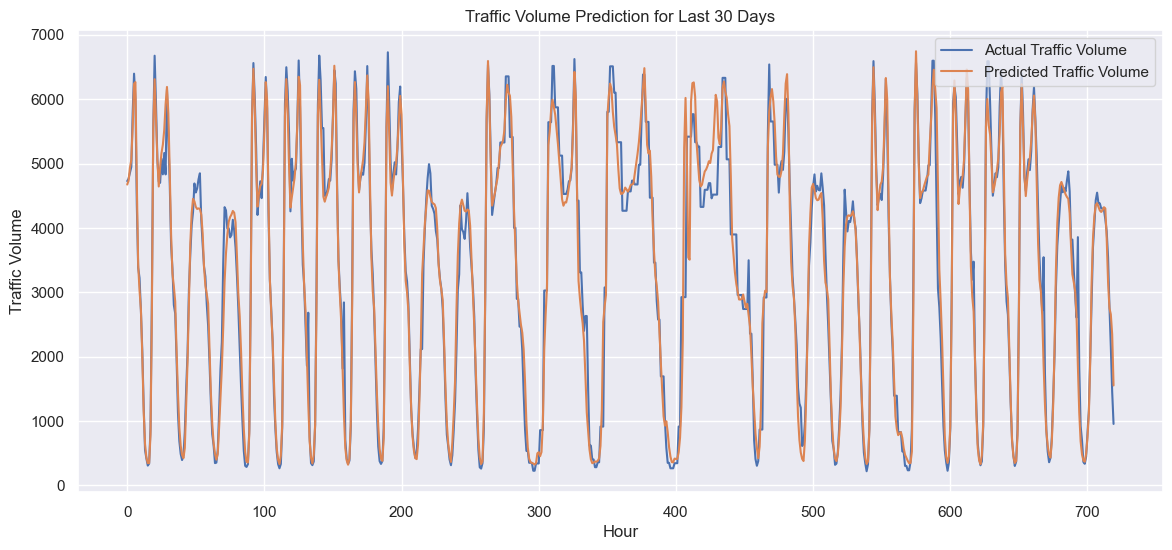

In [35]:
plt.figure(figsize=(14, 6))
plt.plot(y_actual_last, label='Actual Traffic Volume')
plt.plot(y_pred_last, label='Predicted Traffic Volume')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume Prediction for Last 30 Days')
plt.legend()
plt.show()

### Finding R-Squared Value

In [38]:
r2 = r2_score(y_actual_last, y_pred_last)
print(f"R² Score for Last 30 Days: {r2:.4f}")

R² Score for Last 30 Days: 0.9561
